# Dataset de Alquiler en California

Crear 3 modelos de clasificación para el dataset de alquiler en California, uno para cada tipo de clasificador:

- Tree (DecisionTreeClassifier)
- Random Forest (RandomForestClassifier)
- Gradient Boosting (GradientBoostingClassifier)

## Cargar el dataset

In [1]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
X, y = california.data, california.target

In [2]:
import numpy as np
import pandas as pd

df = pd.DataFrame(data=np.c_[X, y], columns=california.feature_names + ['target'])
df.target = df.target.astype(int)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3


In [3]:
df.target.unique() # Esto es para ver cuantos valores unicos hay en la columna target

array([4, 3, 2, 1, 0, 5])

## Visualización de los datos

target
0    3596
1    8289
2    4889
3    2095
4     779
5     992
Name: target, dtype: int64


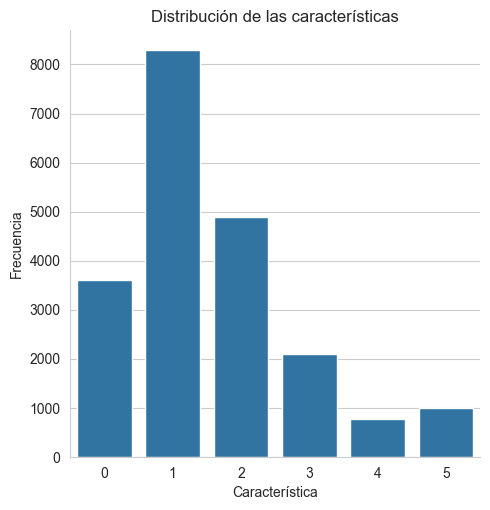

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
print(df["target"].groupby(df["target"]).size())
sns.catplot(x="target", kind="count", data=df)
plt.title('Distribución de las características')
plt.xlabel('Característica')
plt.ylabel('Frecuencia')
plt.show()

## Preparación del conjunto de datos

In [7]:
from sklearn.model_selection import train_test_split

p_train = 0.7

train, test = train_test_split(df, test_size=p_train, random_state=42)

train.reset_index(inplace=True)
test.reset_index(inplace=True)

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

print("Conjunto de entrenamiento:")
print(train.head())

print("Conjunto de prueba:")
print(test.head())

Train: (6192, 10)
Test: (14448, 10)
Conjunto de entrenamiento:
   index  MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
0  18474  3.8788      20.0  5.140069   1.060850      2656.0  3.049369   
1   1203  2.3243      27.0  6.347188   1.063570      1100.0  2.689487   
2   6413  6.5722      34.0  6.194323   1.004367      1344.0  2.934498   
3  17074  2.9286      20.0  2.337963   1.000000       326.0  1.509259   
4    616  3.9500      52.0  6.060870   0.969565       545.0  2.369565   

   Latitude  Longitude  target  
0     37.13    -121.66       2  
1     39.38    -121.74       0  
2     34.11    -118.03       4  
3     37.48    -122.21       2  
4     37.74    -122.15       2  
Conjunto de prueba:
   index  MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
0  20046  1.6812      25.0  4.192201   1.022284      1392.0  3.877437   
1   3024  2.5313      30.0  5.039384   1.193493      1565.0  2.679795   
2  15663  3.4801      52.0  3.977155   1.185877      1310.0  

## Validación cruzada con RandomizedSearchCV

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Crear los clasificadores
tree_classifier = DecisionTreeClassifier()
rnd_classifier = RandomForestClassifier()
gb_classifier = GradientBoostingClassifier()

# Parámetros para los clasificadores
params = {
    'tree': {
        'max_depth': [16, 12, 8, 4, 2, None],
        'criterion': ['gini', 'entropy']
    },
    'rnd': {
        'n_estimators': [4, 8, 16, 32, 64, 128],
        'max_depth': [16, 12, 8, 4, 2, None],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy']
    },
    'gb': {
        'n_estimators': [4, 8, 16, 32, 64, 128],
        'max_depth': [16, 12, 8, 4, 2, None],
        'learning_rate': [0.1, 0.05, 0.02, 0.01]
    }
}

# GridSearchCV
results = {}
for name, classifier in zip(['tree', 'rnd', 'gb'], [tree_classifier, rnd_classifier, gb_classifier]):
    print(f"Clasificador: {name}")
    print(f"{'='*len(name)}")
    result = RandomizedSearchCV(
        estimator=classifier,
        param_distributions=params[name],
        cv=5
    )
    result.fit(X=train.drop(['target'], axis=1), y=train['target'])
    print(f"Mejores parámetros: {result.best_params_}")
    print()
    results[name] = result

Clasificador: tree
====
Mejores parámetros: {'max_depth': 8, 'criterion': 'gini'}

Clasificador: rnd
===
Mejores parámetros: {'n_estimators': 64, 'max_depth': 16, 'criterion': 'entropy', 'bootstrap': False}

Clasificador: gb
==
Mejores parámetros: {'n_estimators': 128, 'max_depth': 16, 'learning_rate': 0.05}


## Evaluación de los modelos

In [9]:
from sklearn.metrics import classification_report

X_train = train.drop(['target'], axis=1)
y_train = train['target']
X_test = test.drop(['target'], axis=1)
y_test = test['target']

# Crear los clasificadores
tree_classifier = DecisionTreeClassifier(**results['tree'].best_params_)
rnd_classifier = RandomForestClassifier(**results['rnd'].best_params_)
gb_classifier = GradientBoostingClassifier(**results['gb'].best_params_)

models = {
    'tree': tree_classifier,
    'rnd': rnd_classifier,
    'gb': gb_classifier
}

# Entrenar los clasificadores
for name, model in models.items():
    model.fit(X_train, y_train)
    
# Evaluar los clasificadores
for name, model in models.items():
    print(f"Clasificador: {name}")
    print(f"=============={'='*len(name)}")
    print(classification_report(y_test, model.predict(X_test)))
    print()

Clasificador: tree
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      2491
           1       0.66      0.77      0.71      5817
           2       0.52      0.50      0.51      3420
           3       0.45      0.31      0.37      1484
           4       0.29      0.14      0.19       533
           5       0.55      0.59      0.57       703

    accuracy                           0.61     14448
   macro avg       0.53      0.50      0.51     14448
weighted avg       0.60      0.61      0.60     14448


Clasificador: rnd
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2491
           1       0.75      0.82      0.78      5817
           2       0.64      0.66      0.65      3420
           3       0.53      0.46      0.49      1484
           4       0.31      0.17      0.22       533
           5       0.69      0.63      0.66       703

    accuracy                           

## Matriz de confusión

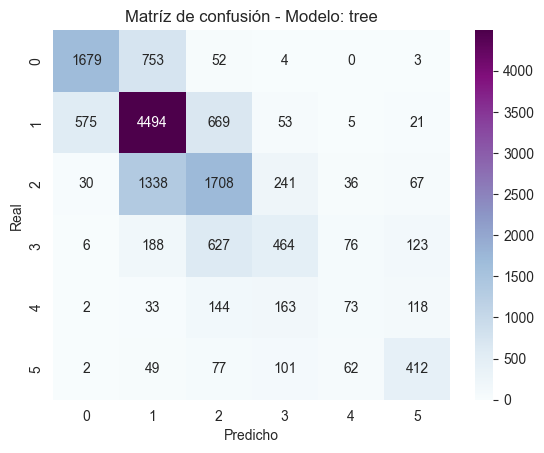

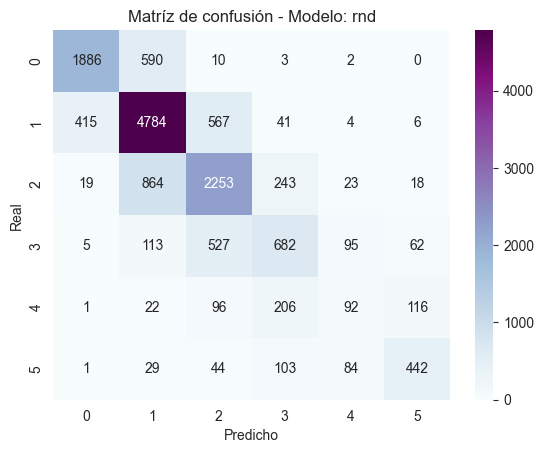

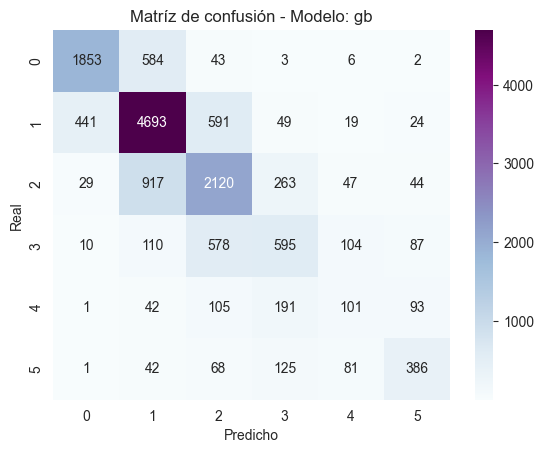

In [10]:
from sklearn.metrics import confusion_matrix

for name, model in models.items():
    confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, cmap='BuPu', fmt='d')
    plt.title(f'Matríz de confusión - Modelo: {name}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()